In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import wn
#nltk.download('all')
from nltk.stem import WordNetLemmatizer 
from nltk.stem import *
import gzip
import gensim 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from collections import Counter
from itertools import chain
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
stop_words = set(stopwords.words('english'))

In [2]:
df_nutrients = pd.read_csv('Nutrients.csv')
df_foods = pd.read_csv('Products.csv', low_memory=False) 

In [3]:
'''
CSV_Merge(203, 'Protein')
CSV_Merge(204, 'Total Lipid (fat)')
CSV_Merge(205, 'Carbohydrate')
CSV_Merge(208, 'Energy (calories)')
CSV_Merge(269, 'Total Sugar')
CSV_Merge(291, 'Fiber')
CSV_Merge(301, 'Calcium')
CSV_Merge(303, 'Iron')
CSV_Merge(307, 'Sodium')
CSV_Merge(324, 'Vitamin D')
CSV_Merge(539, 'Added Sugar')
CSV_Merge(601, 'Cholesterol')
CSV_Merge(605, 'Trans Fat')
CSV_Merge(606, 'Saturated Fat')
'''

list_of_nutrient_codes = [203, 204, 205, 208, 269, 291, 301, 303, 307, 601, 605, 606]
list_of_nutrient_names = ['Protein', 'Total Lipid (fat)', 'Carbohydrate', 'Energy (calories)', 'Total Sugar', 'Fiber',
                         'Calcium', 'Iron', 'Sodium', 'Cholesterol', 'Trans Fat', 'Saturated Fat']

#removed Added Sugar (539) and Vitamin D (324)

for i in range(len(list_of_nutrient_codes)):
    
    #current_nutrient_name = ""
    
    current_nutrient_code = list_of_nutrient_codes[i]
    current_nutrient_name = list_of_nutrient_names[i]
    #print(current_nutrient_name)
    
    df_temp = df_nutrients[(df_nutrients.Nutrient_Code == current_nutrient_code)][['NDB_No', 'Output_value']]
    df_temp = df_temp.set_index('NDB_No').rename(columns={'Output_value': current_nutrient_name})
    df_foods = pd.merge(df_foods, df_temp, how="left", left_on='NDB_Number', right_on='NDB_No')
    

In [4]:
df_foods.isnull().sum(axis = 0)

NDB_Number                 0
long_name                  0
data_source                0
gtin_upc                   0
manufacturer             831
date_modified              0
date_available             0
ingredients_english     2550
Protein                 1657
Total Lipid (fat)       1530
Carbohydrate            1454
Energy (calories)      10598
Total Sugar            15695
Fiber                  40918
Calcium                43024
Iron                   42108
Sodium                  2202
Cholesterol            36123
Trans Fat              44288
Saturated Fat          33395
dtype: int64

In [5]:
df_foods = df_foods.dropna()
df_foods

,NDB_Number,long_name,data_source,gtin_upc,manufacturer,date_modified,date_available,ingredients_english,Protein,Total Lipid (fat),Carbohydrate,Energy (calories),Total Sugar,Fiber,Calcium,Iron,Sodium,Cholesterol,Trans Fat,Saturated Fat
0,45001524,MOCHI ICE CREAM BONBONS,LI,019022128593,"G. T. Japan, Inc.",2017-11-15 19:19:38,2017-11-15 19:19:38,"ICE CREAM INGREDIENTS: MILK, CREAM, SUGAR, STR...",2.50,6.25,35.00,200.0,30.00,0.0,50.0,0.00,75.0,25.0,0.0,3.75
1,45001528,CHIPOTLE BARBECUE SAUCE,LI,5051379043735,FRESH & EASY,2018-04-26 17:23:31,2018-04-26 17:23:31,"WATER, SUGAR, TOMATO PASTE, MOLASSES, DISTILLE...",0.00,0.00,43.24,162.0,37.84,0.0,0.0,0.00,703.0,0.0,0.0,0.00
2,45001529,HOT & SPICY BARBECUE SAUCE,LI,5051379009434,FRESH & EASY,2018-04-26 18:17:37,2018-04-26 18:17:37,"SUGAR, WATER, DISTILLED VINEGAR, TOMATO PASTE,...",0.00,0.00,41.18,176.0,35.29,0.0,0.0,0.00,676.0,0.0,0.0,0.00
3,45001530,BARBECUE SAUCE,LI,5051379019969,FRESH & EASY,2018-04-26 17:24:00,2018-04-26 17:24:00,"TOMATO PUREE (WATER, TOMATO PASTE), SUGAR, DIS...",0.00,0.00,34.29,143.0,28.57,0.0,0.0,0.00,971.0,0.0,0.0,0.00
4,45001531,BARBECUE SAUCE,LI,5051379009526,FRESH & EASY,2018-04-26 17:47:41,2018-04-26 17:47:41,"SUGAR, DISTILLED VINEGAR, WATER, TOMATO PASTE,...",0.00,0.00,45.95,189.0,43.24,0.0,0.0,0.00,757.0,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237647,45374987,STRAWBERRY BANANA PARFAIT,LI,040232667381,Q,2018-06-01 20:49:43,2018-06-01 20:49:43,"LOW FAT VANILLA YOGURT (CULTURED SKIM MILK*, S...",4.61,1.84,25.35,129.0,17.51,1.4,284.0,0.46,69.0,9.0,0.0,0.46
237650,45374991,LINGUINE GARLIC & HERB PASTA,LI,008005913653,Nuovo Pasta Productions Ltd,2018-06-01 20:50:06,2018-06-01 20:50:06,"DURUM SEMOLINA FLOUR, WATER, EGGS, PARSLEY, SP...",11.00,2.50,55.00,270.0,0.00,10.0,29.0,3.00,10.0,20.0,0.0,0.50
237652,45374994,EXTRA CREAMY WHIPPED TOPPING,LI,041380502500,"Unified Grocers, Inc.",2018-06-01 20:51:13,2018-06-01 20:51:13,"SKIM MILK, HYDROGENATED VEGETABLE OIL (COCONUT...",0.00,22.22,22.22,333.0,22.22,0.0,33.0,0.00,56.0,0.0,0.0,22.22
237654,45374996,WHIPPED TOPPING,LI,041380500100,"Unified Grocers, Inc.",2018-05-25 22:07:26,2018-05-25 22:07:26,"WATER, HYDROGENATED VEGETABLE OIL (COCONUT OIL...",0.00,16.67,22.22,278.0,11.11,0.0,11.0,0.00,0.0,0.0,0.0,16.67


In [6]:
def cleanIngredientsList(ingred): #ingred is a string
       
    ingred = re.sub('[^a-zA-Z \n]', ' ', ingred).lower()
    ingred = re.sub('\s+', ' ', ingred)
    ingred = ingred.strip()
    ingred_list = ingred.split(" ")
    
    ingred_list = np.unique(ingred_list)
    
    stop_words = set(stopwords.words('english'))
    ingred_list_no_stop_words = []
    
    
    for w in ingred_list:
        if w not in stop_words:
            ingred_list_no_stop_words.append(w)
    
    stem_word = ""
    final_ingred_list = []
    stemmer = PorterStemmer()
    
    for word in ingred_list_no_stop_words:
        stem_word = stemmer.stem(word)
        final_ingred_list.append(stem_word)
    
    
    return final_ingred_list

In [7]:
#testing clean ingredients function
test_list = df_foods.at[0,"ingredients_english"]
print(test_list)
print(cleanIngredientsList(test_list))

ICE CREAM INGREDIENTS: MILK, CREAM, SUGAR, STRAWBERRIES (STRAWBERRIES, SUGAR), CORN SYRUP SOLIDS, SKIM MILK, WHEY, NATURAL FLAVOR, GUAR GUM, MONO & DIGLYCERIDES, BEET JUICE AND BEET POWDER (FOR COLOR), CELLULOSE GUM, LOCUST BEAN GUM, CARRAGEENAN. COATING INGREDIENTS: SUGAR, WATER, RICE FLOUR, TREHALOSE, EGG WHITES, BEET JUICE AND BEET POWDER (FOR COLOR), DUSTED WITH CORN & POTATO STARCH
['bean', 'beet', 'carrageenan', 'cellulos', 'coat', 'color', 'corn', 'cream', 'diglycerid', 'dust', 'egg', 'flavor', 'flour', 'guar', 'gum', 'ice', 'ingredi', 'juic', 'locust', 'milk', 'mono', 'natur', 'potato', 'powder', 'rice', 'skim', 'solid', 'starch', 'strawberri', 'sugar', 'syrup', 'trehalos', 'water', 'whey', 'white']


In [8]:
df_foods['ing_stem_list'] = df_foods.apply(lambda row: cleanIngredientsList(row.ingredients_english), axis=1)
df_foods

,NDB_Number,long_name,data_source,gtin_upc,manufacturer,date_modified,date_available,ingredients_english,Protein,Total Lipid (fat),...,Energy (calories),Total Sugar,Fiber,Calcium,Iron,Sodium,Cholesterol,Trans Fat,Saturated Fat,ing_stem_list
0,45001524,MOCHI ICE CREAM BONBONS,LI,019022128593,"G. T. Japan, Inc.",2017-11-15 19:19:38,2017-11-15 19:19:38,"ICE CREAM INGREDIENTS: MILK, CREAM, SUGAR, STR...",2.50,6.25,...,200.0,30.00,0.0,50.0,0.00,75.0,25.0,0.0,3.75,"[bean, beet, carrageenan, cellulos, coat, colo..."
1,45001528,CHIPOTLE BARBECUE SAUCE,LI,5051379043735,FRESH & EASY,2018-04-26 17:23:31,2018-04-26 17:23:31,"WATER, SUGAR, TOMATO PASTE, MOLASSES, DISTILLE...",0.00,0.00,...,162.0,37.84,0.0,0.0,0.00,703.0,0.0,0.0,0.00,"[chipotl, contain, corn, distil, dri, flavor, ..."
2,45001529,HOT & SPICY BARBECUE SAUCE,LI,5051379009434,FRESH & EASY,2018-04-26 18:17:37,2018-04-26 18:17:37,"SUGAR, WATER, DISTILLED VINEGAR, TOMATO PASTE,...",0.00,0.00,...,176.0,35.29,0.0,0.0,0.00,676.0,0.0,0.0,0.00,"[caramel, color, concentr, contain, corn, dist..."
3,45001530,BARBECUE SAUCE,LI,5051379019969,FRESH & EASY,2018-04-26 17:24:00,2018-04-26 17:24:00,"TOMATO PUREE (WATER, TOMATO PASTE), SUGAR, DIS...",0.00,0.00,...,143.0,28.57,0.0,0.0,0.00,971.0,0.0,0.0,0.00,"[bourbon, caramel, color, contain, corn, disti..."
4,45001531,BARBECUE SAUCE,LI,5051379009526,FRESH & EASY,2018-04-26 17:47:41,2018-04-26 17:47:41,"SUGAR, DISTILLED VINEGAR, WATER, TOMATO PASTE,...",0.00,0.00,...,189.0,43.24,0.0,0.0,0.00,757.0,0.0,0.0,0.00,"[caramel, color, concentr, contain, corn, dist..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237647,45374987,STRAWBERRY BANANA PARFAIT,LI,040232667381,Q,2018-06-01 20:49:43,2018-06-01 20:49:43,"LOW FAT VANILLA YOGURT (CULTURED SKIM MILK*, S...",4.61,1.84,...,129.0,17.51,1.4,284.0,0.46,69.0,9.0,0.0,0.46,"[acid, activ, ad, ascorb, banana, barley, bulg..."
237650,45374991,LINGUINE GARLIC & HERB PASTA,LI,008005913653,Nuovo Pasta Productions Ltd,2018-06-01 20:50:06,2018-06-01 20:50:06,"DURUM SEMOLINA FLOUR, WATER, EGGS, PARSLEY, SP...",11.00,2.50,...,270.0,0.00,10.0,29.0,3.00,10.0,20.0,0.0,0.50,"[beta, caroten, dillwe, durum, egg, flour, gar..."
237652,45374994,EXTRA CREAMY WHIPPED TOPPING,LI,041380502500,"Unified Grocers, Inc.",2018-06-01 20:51:13,2018-06-01 20:51:13,"SKIM MILK, HYDROGENATED VEGETABLE OIL (COCONUT...",0.00,22.22,...,333.0,22.22,0.0,33.0,0.00,56.0,0.0,0.0,22.22,"[beta, caroten, casein, coconut, color, corn, ..."
237654,45374996,WHIPPED TOPPING,LI,041380500100,"Unified Grocers, Inc.",2018-05-25 22:07:26,2018-05-25 22:07:26,"WATER, HYDROGENATED VEGETABLE OIL (COCONUT OIL...",0.00,16.67,...,278.0,11.11,0.0,11.0,0.00,0.0,0.0,0.0,16.67,"[beta, caroten, casein, coconut, color, corn, ..."


In [9]:
model = Word2Vec(df_foods.ing_stem_list, min_count=1, workers=3, window =3, sg = 1)

2022-08-31 13:07:13,288 : INFO : collecting all words and their counts
2022-08-31 13:07:13,289 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-08-31 13:07:13,331 : INFO : PROGRESS: at sentence #10000, processed 243933 words, keeping 2843 word types
2022-08-31 13:07:13,368 : INFO : PROGRESS: at sentence #20000, processed 497188 words, keeping 3808 word types
2022-08-31 13:07:13,395 : INFO : PROGRESS: at sentence #30000, processed 731280 words, keeping 4503 word types
2022-08-31 13:07:13,436 : INFO : PROGRESS: at sentence #40000, processed 1009213 words, keeping 5363 word types
2022-08-31 13:07:13,468 : INFO : PROGRESS: at sentence #50000, processed 1287413 words, keeping 5925 word types
2022-08-31 13:07:13,497 : INFO : PROGRESS: at sentence #60000, processed 1542213 words, keeping 6634 word types
2022-08-31 13:07:13,529 : INFO : PROGRESS: at sentence #70000, processed 1825258 words, keeping 7107 word types
2022-08-31 13:07:13,564 : INFO : PROGRESS: at sen

In [10]:
list_of_arrays = []

for n in range(len(df_foods)): 
    
    food_item = df_foods.iloc[n]
    item = np.array([model.wv[word] for word in food_item.ing_stem_list]).mean(axis=0).tolist()
    list_of_arrays.append(item)
    
    
df_foods['mean_array'] = list_of_arrays
df_foods

,NDB_Number,long_name,data_source,gtin_upc,manufacturer,date_modified,date_available,ingredients_english,Protein,Total Lipid (fat),...,Total Sugar,Fiber,Calcium,Iron,Sodium,Cholesterol,Trans Fat,Saturated Fat,ing_stem_list,mean_array
0,45001524,MOCHI ICE CREAM BONBONS,LI,019022128593,"G. T. Japan, Inc.",2017-11-15 19:19:38,2017-11-15 19:19:38,"ICE CREAM INGREDIENTS: MILK, CREAM, SUGAR, STR...",2.50,6.25,...,30.00,0.0,50.0,0.00,75.0,25.0,0.0,3.75,"[bean, beet, carrageenan, cellulos, coat, colo...","[-0.03786119446158409, -0.18356823921203613, 0..."
1,45001528,CHIPOTLE BARBECUE SAUCE,LI,5051379043735,FRESH & EASY,2018-04-26 17:23:31,2018-04-26 17:23:31,"WATER, SUGAR, TOMATO PASTE, MOLASSES, DISTILLE...",0.00,0.00,...,37.84,0.0,0.0,0.00,703.0,0.0,0.0,0.00,"[chipotl, contain, corn, distil, dri, flavor, ...","[-0.2105855494737625, -0.16095322370529175, 0...."
2,45001529,HOT & SPICY BARBECUE SAUCE,LI,5051379009434,FRESH & EASY,2018-04-26 18:17:37,2018-04-26 18:17:37,"SUGAR, WATER, DISTILLED VINEGAR, TOMATO PASTE,...",0.00,0.00,...,35.29,0.0,0.0,0.00,676.0,0.0,0.0,0.00,"[caramel, color, concentr, contain, corn, dist...","[-0.18852253258228302, -0.14229875802993774, 0..."
3,45001530,BARBECUE SAUCE,LI,5051379019969,FRESH & EASY,2018-04-26 17:24:00,2018-04-26 17:24:00,"TOMATO PUREE (WATER, TOMATO PASTE), SUGAR, DIS...",0.00,0.00,...,28.57,0.0,0.0,0.00,971.0,0.0,0.0,0.00,"[bourbon, caramel, color, contain, corn, disti...","[-0.15811897814273834, -0.15989911556243896, 0..."
4,45001531,BARBECUE SAUCE,LI,5051379009526,FRESH & EASY,2018-04-26 17:47:41,2018-04-26 17:47:41,"SUGAR, DISTILLED VINEGAR, WATER, TOMATO PASTE,...",0.00,0.00,...,43.24,0.0,0.0,0.00,757.0,0.0,0.0,0.00,"[caramel, color, concentr, contain, corn, dist...","[-0.1670609712600708, -0.14098691940307617, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237647,45374987,STRAWBERRY BANANA PARFAIT,LI,040232667381,Q,2018-06-01 20:49:43,2018-06-01 20:49:43,"LOW FAT VANILLA YOGURT (CULTURED SKIM MILK*, S...",4.61,1.84,...,17.51,1.4,284.0,0.46,69.0,9.0,0.0,0.46,"[acid, activ, ad, ascorb, banana, barley, bulg...","[-0.16431264579296112, -0.10218995809555054, 0..."
237650,45374991,LINGUINE GARLIC & HERB PASTA,LI,008005913653,Nuovo Pasta Productions Ltd,2018-06-01 20:50:06,2018-06-01 20:50:06,"DURUM SEMOLINA FLOUR, WATER, EGGS, PARSLEY, SP...",11.00,2.50,...,0.00,10.0,29.0,3.00,10.0,20.0,0.0,0.50,"[beta, caroten, dillwe, durum, egg, flour, gar...","[-0.3016948699951172, -0.2160738706588745, 0.0..."
237652,45374994,EXTRA CREAMY WHIPPED TOPPING,LI,041380502500,"Unified Grocers, Inc.",2018-06-01 20:51:13,2018-06-01 20:51:13,"SKIM MILK, HYDROGENATED VEGETABLE OIL (COCONUT...",0.00,22.22,...,22.22,0.0,33.0,0.00,56.0,0.0,0.0,22.22,"[beta, caroten, casein, coconut, color, corn, ...","[-0.00537664582952857, -0.1124151200056076, 0...."
237654,45374996,WHIPPED TOPPING,LI,041380500100,"Unified Grocers, Inc.",2018-05-25 22:07:26,2018-05-25 22:07:26,"WATER, HYDROGENATED VEGETABLE OIL (COCONUT OIL...",0.00,16.67,...,11.11,0.0,11.0,0.00,0.0,0.0,0.0,16.67,"[beta, caroten, casein, coconut, color, corn, ...","[-0.009730152785778046, -0.1141701191663742, 0..."


C:\Users\Shark125\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Shark125\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


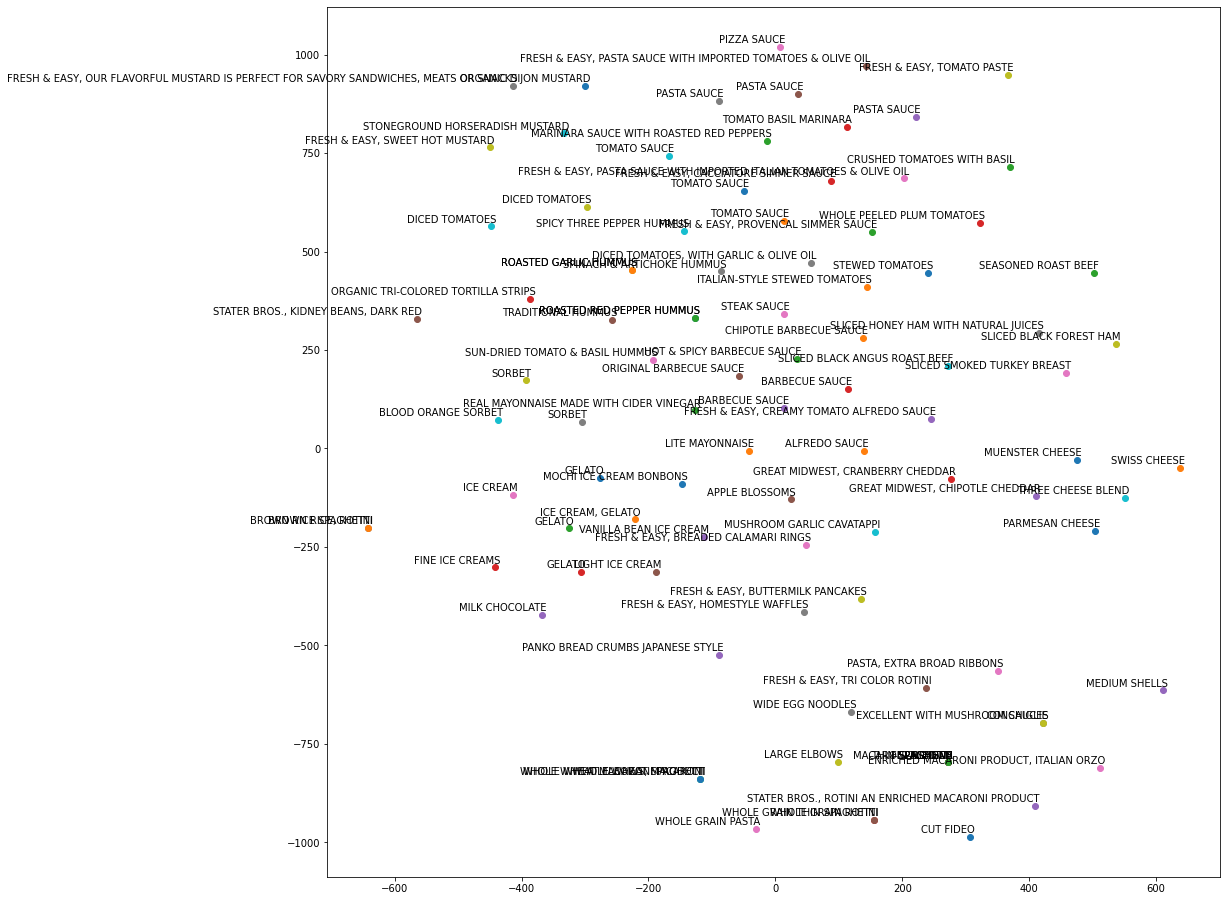

In [11]:
labels = []
tokens = []

for _, food_item in df_foods.iloc[:100].iterrows():
    tokens.append(food_item.mean_array)
    labels.append(food_item.long_name)

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()

In [12]:

train_ind, test_ind = train_test_split(np.arange(len(df_foods)), random_state=42, test_size=0.33, shuffle=True)
print(train_ind)
print(test_ind)


[ 45779  23796  13025 ... 131932 146867 121958]
[  2724 148023 102360 ...  45998   4802  96757]


In [13]:
y = df_foods[list_of_nutrient_names].to_numpy()
y_bin = (y>0).astype(int)

<AxesSubplot:>

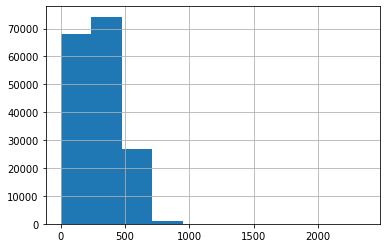

In [14]:
df_foods[list_of_nutrient_names[3]].hist()

In [15]:

X = np.array([np.array(row) for row in df_foods['mean_array'].to_numpy()])

X_train = X[train_ind]
X_test = X[test_ind]

y = df_foods[list_of_nutrient_names].to_numpy()
y_bin = (y>0).astype(int)

y_train = y_bin[train_ind]
y_test = y_bin[test_ind]

print(X_train.shape)
print(X_test.shape)
print(X_train)
print()
print(y_train.shape)
print(y_test.shape)
print(y_train)


(114017, 100)
(56159, 100)
[[-0.12826863 -0.1325818   0.05550917 ... -0.17308536  0.21687201
   0.00741646]
 [-0.32367915 -0.07649171  0.1474591  ... -0.38153872  0.26875466
   0.01914491]
 [-0.06169669 -0.13727179  0.12572964 ... -0.06868739  0.20290479
   0.04944493]
 ...
 [-0.04084413 -0.16390732  0.05997534 ... -0.21729884  0.18593231
  -0.01619353]
 [-0.34181958 -0.1489608   0.03013331 ... -0.12960431  0.08362244
   0.05895936]
 [-0.19954243 -0.21896268  0.03104676 ... -0.22212556  0.10670049
   0.0406716 ]]

(114017, 12)
(56159, 12)
[[1 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 0 1 ... 1 0 0]
 ...
 [1 1 1 ... 1 0 1]
 [1 0 1 ... 0 0 0]
 [1 1 1 ... 1 0 1]]


In [18]:
'''

NB_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words=stop_words)),('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),])


categories = ['Protein', 'Total Lipid (fat)', 'Carbohydrate', 'Energy (calories)', 'Total Sugar', 'Fiber',
                         'Calcium', 'Iron', 'Sodium', 'Cholesterol', 'Trans Fat', 'Saturated Fat'] 

for category in categories:
    
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    
'''

#clf_protein = SVC(kernel='rbf', probability=True).fit(X_train[:1000, :], y_train[:1000, 0]) #88%
#clf_fat = SVC(kernel='rbf', probability=True).fit(X_train[:1000, :], y_train[:1000, 1]) #89%
#clf_carb = SVC(kernel='rbf', probability=True).fit(X_train[:1000, :], y_train[:1000, 2]) #79%


#print(clf_sfat.predict([X_test[0, :]]), 'PREDICTED')
#print(y_test[0, 9], 'GROUND TRUTH')


"\n\nNB_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words=stop_words)),('clf', OneVsRestClassifier(MultinomialNB(\n                    fit_prior=True, class_prior=None))),])\n\n\ncategories = ['Protein', 'Total Lipid (fat)', 'Carbohydrate', 'Energy (calories)', 'Total Sugar', 'Fiber',\n                         'Calcium', 'Iron', 'Sodium', 'Cholesterol', 'Trans Fat', 'Saturated Fat'] \n\nfor category in categories:\n    \n    print('... Processing {}'.format(category))\n    # train the model using X_dtm & y\n    SVC_pipeline.fit(X_train, train[category])\n    # compute the testing accuracy\n    prediction = SVC_pipeline.predict(X_test)\n    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))\n    \n"

In [20]:
#y_pred = clf_carb.predict(X_test)
#y_pred

In [21]:
#y_test[:, 2]

In [22]:
#(y_pred == y_test[:, 2]).sum() / len(y_pred)

In [23]:
def accuracy(category, kernel): 
    
    train_ind, test_ind = train_test_split(np.arange(len(df_foods)), test_size=0.33, shuffle=True)
    total_sum = 0
    
    for i in range(10): 
        
        train_ind, test_ind = train_test_split(np.arange(len(df_foods)), test_size=0.33, shuffle=True)
        
        X = np.array([np.array(row) for row in df_foods['mean_array'].to_numpy()])

        X_train = X[train_ind]
        X_test = X[test_ind]

        y = df_foods[list_of_nutrient_names].to_numpy()
        y_bin = (y>0).astype(int)

        y_train = y_bin[train_ind]
        y_test = y_bin[test_ind]
        
        
    
        clf = SVC(kernel=kernel).fit(X_train[:1000, :], y_train[:1000, category])
        y_pred = clf.predict(X_test)
        
        total_sum = total_sum + (y_pred == y_test[:, category]).sum() / len(y_pred)
        #print(total_sum)
    
    print("Accuracy = " + str(total_sum / 10))
    

In [24]:
accuracy(1, "rbf")

Accuracy = 0.8919923787816735


(56159,)
(56159,)


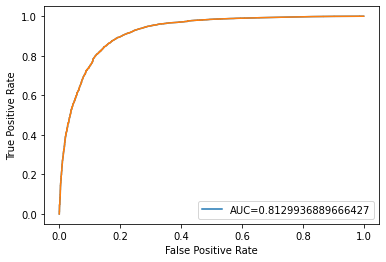

In [82]:
y_pred_proba = clf_fat.predict_proba(X_test)[::,1]
#y_pred_proba.reshape(-1, 1)

#print(y_test[0])
print(y_test[:, 1].shape)
print(y_pred_proba.shape)


fpr, tpr, _ = metrics.roc_curve(y_test[:, 1],  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba.reshape(-1, 1))

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
#protein: AUC=0.8952
#fat: AUC=0.81299

Accuracy = 0.8830926476611051


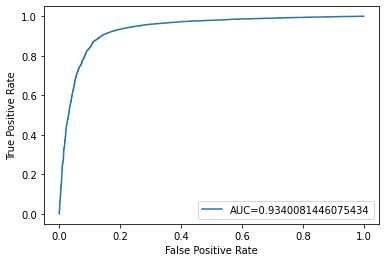

In [25]:
#Protein
accuracy(0, "rbf")

clf_protein = SVC(kernel='rbf', probability=True).fit(X_train[:10000, :], y_train[:10000, 0])

y_pred_proba = clf_protein.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test[:, 0],  y_pred_proba)
auc = metrics.roc_auc_score(y_test[:, 0], y_pred_proba.reshape(-1, 1))

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Accuracy = 0.8930874837514912


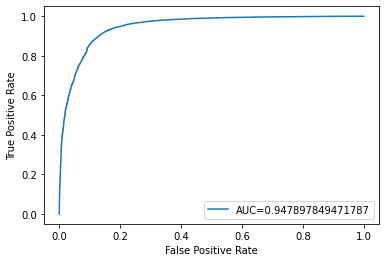

In [26]:
#Fat
accuracy(1, "rbf")

clf_fat = SVC(kernel='rbf', probability=True).fit(X_train[:10000, :], y_train[:10000, 1])

y_pred_proba = clf_fat.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test[:, 1],  y_pred_proba)
auc = metrics.roc_auc_score(y_test[:, 1], y_pred_proba.reshape(-1, 1))

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Accuracy = 0.9516942965508643


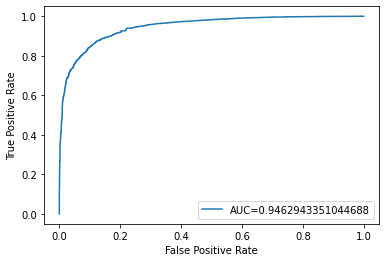

In [27]:
#Carbohydrates
accuracy(2, "rbf")

clf_carb = SVC(kernel='rbf', probability=True).fit(X_train[:10000, :], y_train[:10000, 2])

y_pred_proba = clf_carb.predict_proba(X_test)[:,1]

fpr, tpr, _ = metrics.roc_curve(y_test[:, 2],  y_pred_proba)
auc = metrics.roc_auc_score(y_test[:, 2], y_pred_proba.reshape(-1, 1))

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Accuracy = 0.9929022952687905


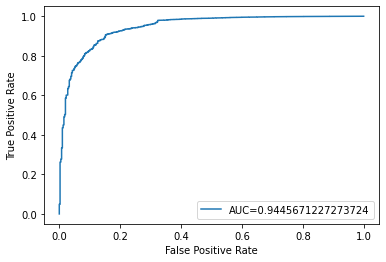

In [28]:
#Calories (Engergy)
accuracy(3, "rbf")

clf_cal = SVC(kernel='rbf', probability=True).fit(X_train[:10000, :], y_train[:10000, 3])

y_pred_proba = clf_cal.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test[:, 3],  y_pred_proba)
auc = metrics.roc_auc_score(y_test[:, 3], y_pred_proba.reshape(-1, 1))

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Accuracy = 0.8612315034099609


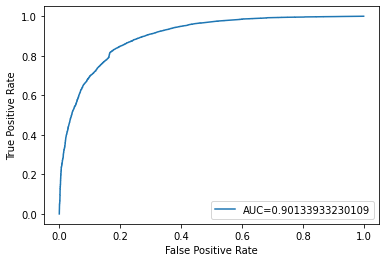

In [29]:
#Total Sugar
accuracy(4, "rbf")

clf_sugar = SVC(kernel='rbf', probability=True).fit(X_train[:10000, :], y_train[:10000, 4])

y_pred_proba = clf_sugar.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test[:, 4],  y_pred_proba)
auc = metrics.roc_auc_score(y_test[:, 4], y_pred_proba.reshape(-1, 1))

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Accuracy = 0.8064940615039442


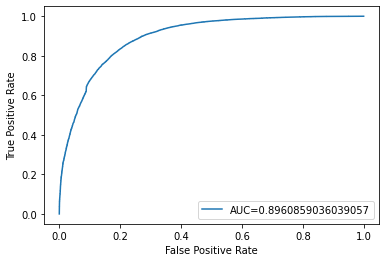

In [30]:
#Fiber
accuracy(5, "rbf")

clf_fiber = SVC(kernel='rbf', probability=True).fit(X_train[:10000, :], y_train[:10000, 5])

y_pred_proba = clf_fiber.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test[:, 5],  y_pred_proba)
auc = metrics.roc_auc_score(y_test[:, 5], y_pred_proba.reshape(-1, 1))

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Accuracy = 0.7258248900443384


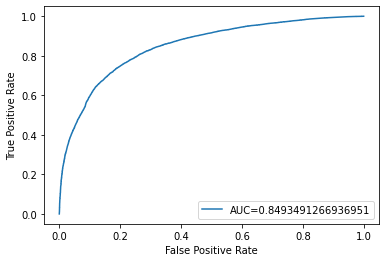

In [31]:
#Calcium
accuracy(6, "rbf")

clf_calc = SVC(kernel='rbf', probability=True).fit(X_train[:10000, :], y_train[:10000, 6])

y_pred_proba = clf_calc.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test[:, 6],  y_pred_proba)
auc = metrics.roc_auc_score(y_test[:, 6], y_pred_proba.reshape(-1, 1))

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Accuracy = 0.820835484962339


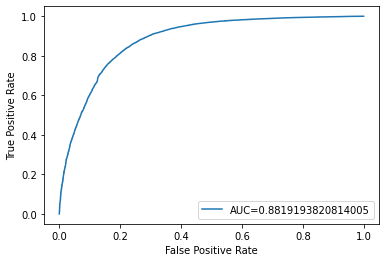

In [32]:
#Iron
accuracy(7, "rbf")

clf_iron = SVC(kernel='rbf', probability=True).fit(X_train[:10000, :], y_train[:10000, 7])

y_pred_proba = clf_iron.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test[:, 7],  y_pred_proba)
auc = metrics.roc_auc_score(y_test[:, 7], y_pred_proba.reshape(-1, 1))

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Accuracy = 0.9191883758613935


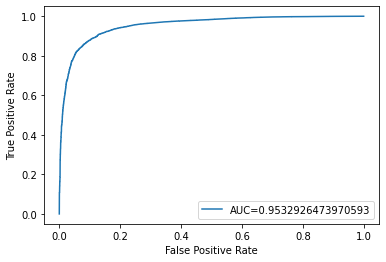

In [33]:
#Sodium
accuracy(8, "rbf")

clf_sod = SVC(kernel='rbf', probability=True).fit(X_train[:10000, :], y_train[:10000, 8])

y_pred_proba = clf_sod.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test[:, 8],  y_pred_proba)
auc = metrics.roc_auc_score(y_test[:, 8], y_pred_proba.reshape(-1, 1))

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Accuracy = 0.8578696201855447


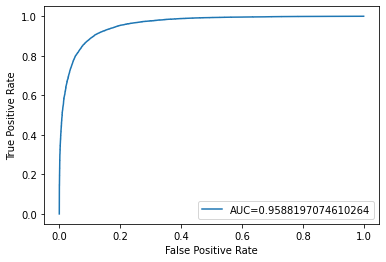

In [34]:
#Cholesterol
accuracy(9, "rbf")

clf_chol = SVC(kernel='rbf', probability=True).fit(X_train[:10000, :], y_train[:10000, 9])

y_pred_proba = clf_chol.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test[:, 9],  y_pred_proba)
auc = metrics.roc_auc_score(y_test[:, 9], y_pred_proba.reshape(-1, 1))

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Accuracy = 0.9829484143236169


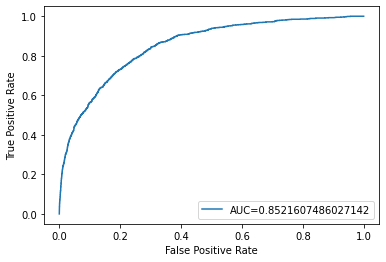

In [35]:
#Trans Fat
accuracy(10, "rbf")

clf_tfat = SVC(kernel='rbf', probability=True).fit(X_train[:10000, :], y_train[:10000, 10])

y_pred_proba = clf_tfat.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test[:, 10],  y_pred_proba)
auc = metrics.roc_auc_score(y_test[:, 10], y_pred_proba.reshape(-1, 1))

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Accuracy = 0.8341583717658791


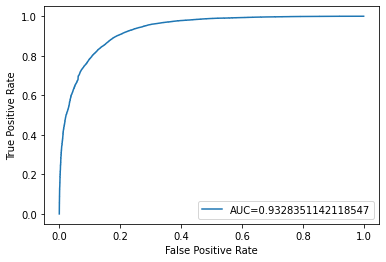

In [36]:
#Saturated Fat
accuracy(11, "rbf")

clf_sfat = SVC(kernel='rbf', probability=True).fit(X_train[:10000, :], y_train[:10000, 11])

y_pred_proba = clf_sfat.predict_proba(X_test)[::,1]

fpr, tpr, _ = metrics.roc_curve(y_test[:, 11],  y_pred_proba)
auc = metrics.roc_auc_score(y_test[:, 11], y_pred_proba.reshape(-1, 1))

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [37]:
#predicting the nutrients of a test food

#print(clf_fat.predict([X_test[0, :]]), 'PREDICTED')
#print(y_test[0, 0], 'GROUND TRUTH')

better_df_foods = df_foods[['long_name', 'ingredients_english', 'Protein', 'Total Lipid (fat)', 'Carbohydrate', 
                            'Energy (calories)', 'Total Sugar', 'Fiber', 'Calcium', 'Iron', 'Sodium', 'Cholesterol',
                            'Trans Fat', 'Saturated Fat']].copy()

#test_ind[0] for later

def food_accuracy (index): 
    
    print(better_df_foods.iloc[test_ind[index]])
    print(" ")
    
    print("Predicted Values: ")
    print(clf_protein.predict([X_test[index, :]]), 'Protein')
    print(clf_fat.predict([X_test[index, :]]), 'Fat')
    print(clf_carb.predict([X_test[index, :]]), 'Carbs')
    print(clf_cal.predict([X_test[index, :]]), 'Calories')
    print(clf_sugar.predict([X_test[index, :]]), 'Total Sugar')
    print(clf_fiber.predict([X_test[index, :]]), 'Fiber')
    print(clf_calc.predict([X_test[index, :]]), 'Calcium')
    print(clf_iron.predict([X_test[index, :]]), 'Iron')
    print(clf_sod.predict([X_test[index, :]]), 'Sodium')
    print(clf_chol.predict([X_test[index, :]]), 'Cholesterol')
    print(clf_tfat.predict([X_test[index, :]]), 'Trans fat')
    print(clf_sfat.predict([X_test[index, :]]), 'Saturated Fat')
    print(" ")
    print(" ")
    print("GROUND TRUTH:", y_test[index])
    print(" ")
    
    predicted_array = np.array([clf_protein.predict([X_test[index, :]]), clf_fat.predict([X_test[index, :]]), 
                               clf_carb.predict([X_test[index, :]]), clf_cal.predict([X_test[index, :]]), 
                                clf_sugar.predict([X_test[index, :]]), clf_fiber.predict([X_test[index, :]]), 
                               clf_calc.predict([X_test[index, :]]), clf_iron.predict([X_test[index, :]]), 
                               clf_sod.predict([X_test[index, :]]), clf_chol.predict([X_test[index, :]]),
                               clf_tfat.predict([X_test[index, :]]), clf_sfat.predict([X_test[index, :]]) ])
    
    final_array = predicted_array.flatten(order='C')
    
    print("PREDICTION:  ", final_array)
    




In [40]:
food_accuracy(2)

long_name              ORGANIC WHOLE GROUND FLAXSEED MEAL
ingredients_english               ORGANIC WHOLE FLAXSEED.
Protein                                             23.08
Total Lipid (fat)                                   34.62
Carbohydrate                                        30.77
Energy (calories)                                   538.0
Total Sugar                                           0.0
Fiber                                                23.1
Calcium                                             154.0
Iron                                                 5.54
Sodium                                                0.0
Cholesterol                                           0.0
Trans Fat                                             0.0
Saturated Fat                                         0.0
Name: 138672, dtype: object
 
Predicted Values: 
[1] Protein
[1] Fat
[1] Carbs
[1] Calories
[0] Total Sugar
[1] Fiber
[1] Calcium
[1] Iron
[0] Sodium
[0] Cholesterol
[0] Trans fat
[0] Satu

In [41]:
#returns true if the predicted food and actual food arrays are identical
def compare_arrays_binary (index):
    
    predicted_array = np.array([clf_protein.predict([X_test[index, :]]), clf_fat.predict([X_test[index, :]]), 
                               clf_carb.predict([X_test[index, :]]), clf_cal.predict([X_test[index, :]]), 
                                clf_sugar.predict([X_test[index, :]]), clf_fiber.predict([X_test[index, :]]), 
                               clf_calc.predict([X_test[index, :]]), clf_iron.predict([X_test[index, :]]), 
                               clf_sod.predict([X_test[index, :]]), clf_chol.predict([X_test[index, :]]),
                               clf_tfat.predict([X_test[index, :]]), clf_sfat.predict([X_test[index, :]]) ])
    
    final_array = predicted_array.flatten(order='C')    
    

    comparison = y_test[index] == final_array
    equal_arrays = comparison.all()
    
    return equal_arrays

In [44]:
compare_arrays_binary(2)

True

In [45]:
def perfect_food_accuracy (number_of_foods): 
    
    counter = 0
   
    for i in range(number_of_foods): 
                
        if compare_arrays_binary(i) == True: 
            counter+=1
        
    print("Food Accuracy: " + str(counter/number_of_foods))
            

In [46]:
perfect_food_accuracy(100)
#35 out of 100 foods are perfectly predicted <-- from yesterday

Food Accuracy: 0.37


In [47]:
#returns the amount of correct predictions in one food (12 means perfect)
def compare_arrays_exactly (index): 
    
    predicted_array = np.array([clf_protein.predict([X_test[index, :]]), clf_fat.predict([X_test[index, :]]), 
                               clf_carb.predict([X_test[index, :]]), clf_cal.predict([X_test[index, :]]), 
                                clf_sugar.predict([X_test[index, :]]), clf_fiber.predict([X_test[index, :]]), 
                               clf_calc.predict([X_test[index, :]]), clf_iron.predict([X_test[index, :]]), 
                               clf_sod.predict([X_test[index, :]]), clf_chol.predict([X_test[index, :]]),
                               clf_tfat.predict([X_test[index, :]]), clf_sfat.predict([X_test[index, :]]) ])
    
    final_array = predicted_array.flatten(order='C')  
    
    return np.sum(y_test[index] == final_array)

In [48]:
compare_arrays_exactly(0)
#yesterday this returned 9

11

In [53]:
def food_accuracy (number_of_foods): 
    
    counter = 0
    
    for i in range(number_of_foods): 
        
        percent = compare_arrays_exactly(i)
        
        counter = counter + percent
    
    print("Food Accuracy: " + str(counter/number_of_foods))
    
    

In [55]:
food_accuracy(1000)
#yesterday this returned 0.75?????

Food Accuracy: 10.793
